In [155]:
import pandas as pd
import qgrid
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed

In [98]:
sample = pd.read_csv("../data/samples/SAMPLES_Excel.tsv",sep='\t')

In [99]:
jfcf_alt = sample[(sample['Immortal'].str.contains("JF"))
                  & (sample['TMM'] == 'ALT')]['Immortal'].values
jfcf_tel = sample[(sample['Immortal'].str.contains("JF"))
                  & (sample['TMM'] == 'TEL')]['Immortal'].values

In [100]:
def split_gene(df, index, sep='&'):
    tmp = pd.DataFrame(columns=df.columns)
    row= df.iloc[index,:]
    genes = row['Gene.refGene']
    for gene in genes.split(sep):
        if gene == 'NONE':
            continue
        row['Gene.refGene'] = gene
        tmp = tmp.append(row)
    return tmp

# all

In [113]:
annovar_df = pd.read_csv("../data/annovar/combined_somatic.tsv", sep='\t')

In [114]:
gridss_df = pd.read_csv("../data/gridss/DATA_GRIDSS.tsv",sep='\t')

gridss_df = gridss_df[gridss_df['Key'].str.contains('Somatic')].reset_index(drop=True)

In [115]:
sv_df = pd.merge(gridss_df.groupby(
    ['Name']).size().reset_index(name='SV_by_mutation'),
                 gridss_df.drop_duplicates(['Gene', 'Name']).groupby(
                     ['Name']).size().reset_index(name='SV_by_gene'),
                 on=['Name'])

In [116]:
annovar_df_with_semi_colon = annovar_df[annovar_df['Gene.refGene'].str.contains(";")].reset_index(drop=True)

In [117]:
annovar_df_with_semi_colon_split = Parallel(n_jobs=14, prefer="threads")(
    delayed(split_gene)(annovar_df_with_semi_colon, i, sep=';')
    for i in trange(annovar_df_with_semi_colon.shape[0]))
annovar_df_with_semi_colon_split = pd.concat(annovar_df_with_semi_colon_split)

<ipython-input-100-2bc57eaa1b7f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Gene.refGene'] = gene


In [119]:
annovar_df = pd.concat([
    annovar_df[~((annovar_df['Gene.refGene'].str.contains(";")) |
               (annovar_df['Gene.refGene'].str.contains("&")))],
    annovar_df_with_semi_colon_split
])

In [120]:
annovar_df.to_csv("../data/annovar/combined_somatic_split.tsv.gz", index=False, sep='\t')

In [38]:
annovar_df = pd.read_csv("../data/annovar/combined_somatic_split.tsv.gz", sep='\t')

In [123]:
annovar_df['Key'] = annovar_df.apply(
    lambda row:
    f"{row['Chr']}_{row['Start']}_{row['End']}_{row['Ref']}_{row['Alt']}_{row['Gene.refGene']}",axis=1)

In [124]:
annovar_df['Type'] = annovar_df.apply(
    lambda row:'SNP' if len(row['Ref']) == len(row['Alt']) else 'INDEL',axis=1)

In [125]:
annovar_df['sample'] = annovar_df['sample'].map(
    lambda x: x.replace('-', '_').replace('JFCF6', 'JFCF_6').replace(
        'JFCF_61M', 'JFCF_6_T_1_M').replace('JFCF_61Q', 'JFCF_6_T_1_Q').replace('PALT','P_ALT'))
annovar_df.loc[annovar_df['sample'] == 'JFCF_6_T_1_P', 'sample'] = 'JFCF_6_T_1_P_TEL'

In [126]:
annovar_df_snp = annovar_df[annovar_df['Type']=='SNP'].reset_index(drop=True)
annovar_df_indel = annovar_df[annovar_df['Type']=='INDEL'].reset_index(drop=True)

In [127]:
snp_df = pd.merge(
    annovar_df_snp.drop_duplicates(['Gene.refGene', 'sample', 'Key']).groupby(['sample'
                            ]).size().reset_index(name='SNP_by_mutation'),
    annovar_df_snp.drop_duplicates(['Gene.refGene', 'sample']).groupby(
        ['sample']).size().reset_index(name='SNP_by_gene'))
snp_df = snp_df.rename(columns={'sample':'Name'})

In [128]:
indel_df = pd.merge(
    annovar_df_indel.drop_duplicates(['Gene.refGene', 'sample', 'Key']).groupby(['sample'
                            ]).size().reset_index(name='INDEL_by_mutation'),
    annovar_df_indel.drop_duplicates(['Gene.refGene', 'sample']).groupby(
        ['sample']).size().reset_index(name='INDEL_by_gene'))
indel_df = indel_df.rename(columns={'sample':'Name'})

In [129]:
all_mutations_count = pd.merge(pd.merge(snp_df, indel_df),sv_df)

In [130]:
all_mutations_count

,Name,SNP_by_mutation,SNP_by_gene,INDEL_by_mutation,INDEL_by_gene,SV_by_mutation,SV_by_gene
0,JFCF_6_T_1J_11C,12785,5909,1048,938,120,59
1,JFCF_6_T_1J_11E,12452,6232,1280,1141,107,60
2,JFCF_6_T_1J_1_3C,19643,8527,6417,4821,166,85
3,JFCF_6_T_1J_6B,20012,8566,6535,4782,193,91
4,JFCF_6_T_1_C,9693,5042,671,614,91,38
5,JFCF_6_T_1_D,9107,4788,526,487,72,47
6,JFCF_6_T_1_F,8046,4561,768,713,200,90
7,JFCF_6_T_1_G,8082,4464,568,522,198,86
8,JFCF_6_T_1_H,9550,4879,730,658,118,57
9,JFCF_6_T_1_L,9717,5067,625,577,70,41


In [131]:
all_mutations_count.to_csv("../results/all_mutations_count.csv", index=False)

In [132]:
jfcf_alt

array(['JFCF_6_P_pLKO_5', 'JFCF_6_T_1_D', 'JFCF_6_T_1_L', 'JFCF_6_T_1_M',
       'JFCF_6_T_1_P_ALT', 'JFCF_6_T_1_Q', 'JFCF_6_T_1_R',
       'JFCF_6_T_1J_1_3C', 'JFCF_6_T_1J_11E', 'JFCF_6_T_5K'], dtype=object)

In [133]:
annovar_df['sample'].unique()

array(['JFCF_6_T_1J_11C', 'JFCF_6_T_1J_11E', 'JFCF_6_T_1_C',
       'JFCF_6_T_1_D', 'JFCF_6_T_1_F', 'JFCF_6_T_1_G', 'JFCF_6_T_1_H',
       'JFCF_6_T_1_L', 'JFCF_6_T_1_P_TEL', 'JFCF_6_T_1_P_ALT',
       'JFCF_6_T_1_R', 'JFCF_6_T_2H', 'JFCF_6_T_5K', 'JFCF_6_T_1J_1_3C',
       'JFCF_6_T_1J_6B', 'JFCF_6_T_1_M', 'JFCF_6_T_1_Q'], dtype=object)

In [134]:
alt_mutations = annovar_df[annovar_df['sample'].isin(jfcf_alt)]['Key'].unique()
tel_mutations = annovar_df[annovar_df['sample'].isin(jfcf_tel)]['Key'].unique()

alt_genes = annovar_df[annovar_df['sample'].isin(jfcf_alt)]['Gene.refGene'].unique()
tel_genes = annovar_df[annovar_df['sample'].isin(jfcf_tel)]['Gene.refGene'].unique()

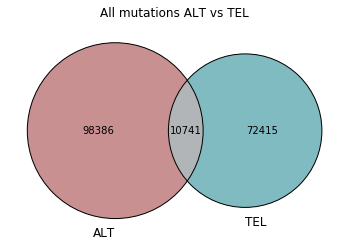

In [135]:
venn2([set(alt_mutations), set(tel_mutations)],
      set_labels=('ALT', 'TEL'),
      set_colors=('#92222249', '#00788249'),
      alpha=.5)
venn2_circles([set(alt_mutations), set(tel_mutations)],
              linewidth=1,
              color="black")
plt.title("All mutations ALT vs TEL")
plt.savefig("../plots/all_mutation.pdf", dpi=500)

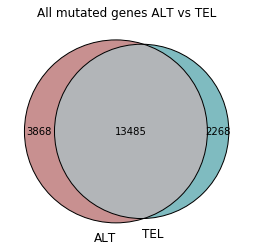

In [136]:
venn2([set(alt_genes), set(tel_genes)],
      set_labels=('ALT', 'TEL'),
      set_colors=('#92222249', '#00788249'),
      alpha=.5)
venn2_circles([set(alt_genes), set(tel_genes)], linewidth=1, color="black")
plt.title("All mutated genes ALT vs TEL")
plt.savefig("../plots/all_mutated_genes.pdf", dpi=500)

# non-silient

In [137]:
df = pd.read_csv("../data/annovar/annovar_mutect_gridss_coding_split.tsv",sep='\t', low_memory=False)

df = df[df['ExonicFunc.refGene'] != 'synonymous SNV'].reset_index(drop=True)

df = df[~((df['Source']=='GRIDSS')&(~df['Key'].str.contains("Somatic")))]

df = df[~df['Type'].isin(['downstream', 'UTR5', 'upstream', 'UTR3', 'upstream;downstream'])]

In [141]:
df['category'] = df.apply(lambda row: 'SV'
                          if row['Source'] == 'GRIDSS' else "SNP"
                          if len(row['Ref1']) == len(row['Alt1']) else 'INDEL',
                          axis=1)

In [142]:
res_df = pd.merge(
    annovar_df_snp.groupby(['sample'
                            ]).size().reset_index(name='SNP_by_mutation'),
    annovar_df_snp.drop_duplicates(['Gene.refGene', 'sample']).groupby(
        ['sample']).size().reset_index(name='SNP_by_gene'))

In [146]:
res_nonsilient = pd.merge(
    pd.pivot(df.groupby(['Name', 'category']).size().reset_index(name='count'),
             index='Name',
             columns='category',
             values='count').reset_index(),
    pd.pivot(df.drop_duplicates(['Gene', 'Name']).groupby(
        ['Name', 'category']).size().reset_index(name='count'),
             index='Name',
             columns='category',
             values='count').reset_index(),
    on='Name',
    suffixes=["_by_mutation", '_by_gene']).fillna(0)

In [147]:
res_nonsilient

category,Name,INDEL_by_mutation,SNP_by_mutation,SV_by_mutation,INDEL_by_gene,SNP_by_gene,SV_by_gene
0,JFCF_6_T_1J_11C,4.0,89.0,42.0,3.0,84.0,29.0
1,JFCF_6_T_1J_11E,2.0,80.0,44.0,1.0,77.0,37.0
2,JFCF_6_T_1J_1_3C,14.0,131.0,35.0,13.0,112.0,25.0
3,JFCF_6_T_1J_6B,17.0,146.0,29.0,16.0,126.0,26.0
4,JFCF_6_T_1_C,1.0,72.0,35.0,1.0,67.0,29.0
5,JFCF_6_T_1_D,2.0,48.0,36.0,2.0,46.0,32.0
6,JFCF_6_T_1_F,2.0,46.0,148.0,2.0,44.0,61.0
7,JFCF_6_T_1_G,0.0,50.0,126.0,0.0,46.0,76.0
8,JFCF_6_T_1_H,5.0,74.0,73.0,4.0,70.0,46.0
9,JFCF_6_T_1_L,3.0,68.0,31.0,3.0,59.0,24.0


In [148]:
res_nonsilient.to_csv("../results/nonsilient_mutations_count.csv", index=False)

## venn

In [149]:
alt_mutations = df[df['Name'].isin(jfcf_alt)]['Key'].unique()
tel_mutations = df[df['Name'].isin(jfcf_tel)]['Key'].unique()

alt_genes = df[df['Name'].isin(jfcf_alt)]['Gene'].unique()
tel_genes = df[df['Name'].isin(jfcf_tel)]['Gene'].unique()

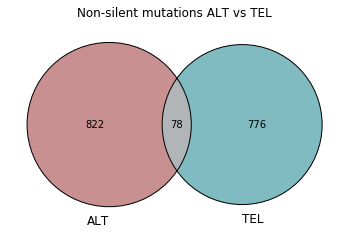

In [150]:
venn2([set(alt_mutations), set(tel_mutations)],
      set_labels=('ALT', 'TEL'),
      set_colors=('#92222249', '#00788249'),
      alpha=.5)
venn2_circles([set(alt_mutations), set(tel_mutations)],
              linewidth=1,
              color="black")
plt.title("Non-silent mutations ALT vs TEL")
plt.savefig("../plots/non_silient_mutation.pdf", dpi=500)

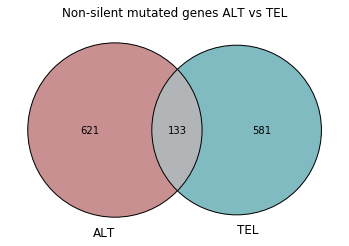

In [151]:
venn2([set(alt_genes), set(tel_genes)], set_labels = ('ALT', 'TEL'), set_colors=('#92222249', '#00788249'), alpha=.5)
venn2_circles([set(alt_genes), set(tel_genes)], linewidth=1, color="black")
plt.title("Non-silent mutated genes ALT vs TEL")
plt.savefig("../plots/non_silient_mutated_genes.pdf", dpi=500)

# 7q venn

In [156]:
df = pd.read_excel("../data/ForSimon_vennyPlot.xlsx")

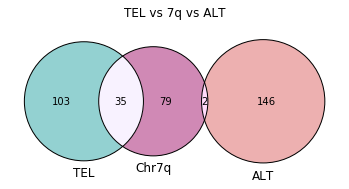

In [170]:
venn3([
    set(df['significantly differentially expressed in ALT']),
    set(df['Chr7q gene']),
    set(df['significantly differentially expressed in TEL'])
],
      set_labels=('ALT', 'Chr7q',
                  'TEL'),
      set_colors=('#EDB0B0', '#D089B5', '#93D1D1'),
      alpha=1)
venn3_circles([
    set(df['significantly differentially expressed in ALT']),
    set(df['Chr7q gene']),
    set(df['significantly differentially expressed in TEL'])
],
              linewidth=1,
              color="black")
plt.title("TEL vs 7q vs ALT")
plt.savefig("../plots/tel_7q_alt.pdf", dpi=500)

# cell line mutations

In [173]:
all_mutations = pd.read_csv("../data/annovar/combined_somatic_split_with_SV.tsv.gz", low_memory=False)

In [177]:
df = pd.read_csv("../data/annovar/annovar_mutect_gridss_coding_split.tsv",sep='\t', low_memory=False)

df = df[df['ExonicFunc.refGene'] != 'synonymous SNV'].reset_index(drop=True)

df = df[~((df['Source']=='GRIDSS')&(~df['Key'].str.contains("Somatic")))]

df = df[~df['Type'].isin(['downstream', 'UTR5', 'upstream', 'UTR3', 'upstream;downstream'])]

In [176]:
all_mutations.drop_duplicates(['Name', 'Gene']).groupby(['Name']).size()

Name
JFCF_6_T_1J_11C      6311
JFCF_6_T_1J_11E      6717
JFCF_6_T_1J_1_3C    10503
JFCF_6_T_1J_6B      10465
JFCF_6_T_1_C         5327
JFCF_6_T_1_D         5019
JFCF_6_T_1_F         4966
JFCF_6_T_1_G         4732
JFCF_6_T_1_H         5176
JFCF_6_T_1_L         5301
JFCF_6_T_1_M         6691
JFCF_6_T_1_P_ALT     5258
JFCF_6_T_1_P_TEL     5108
JFCF_6_T_1_Q         8151
JFCF_6_T_1_R         5944
JFCF_6_T_2H          4560
JFCF_6_T_5K          5610
dtype: int64

In [178]:
df.drop_duplicates(['Name', 'Gene']).groupby(['Name']).size()

Name
JFCF_6_T_1J_11C     116
JFCF_6_T_1J_11E     115
JFCF_6_T_1J_1_3C    150
JFCF_6_T_1J_6B      168
JFCF_6_T_1_C         97
JFCF_6_T_1_D         80
JFCF_6_T_1_F        107
JFCF_6_T_1_G        122
JFCF_6_T_1_H        120
JFCF_6_T_1_L         86
JFCF_6_T_1_M         81
JFCF_6_T_1_P_ALT     65
JFCF_6_T_1_P_TEL     95
JFCF_6_T_1_Q        117
JFCF_6_T_1_R        131
JFCF_6_T_2H          57
JFCF_6_T_5K         112
dtype: int64

In [180]:
res_df = pd.DataFrame({
    'all_mutated_genes':
    all_mutations.drop_duplicates(['Name', 'Gene']).groupby(['Name']).size(),
    'non_silient_mutated_genes':
    df.drop_duplicates(['Name', 'Gene']).groupby(['Name']).size()
})

In [182]:
res_df.to_csv("../results/mutated_genes_counts.csv")